# Power Nap vs Coffee Effectiveness Dataset - EDA and Preprocessing Pipelines

## Introduction

Utilizare el dataset de Power Nap vs Coffee Effectiveness Dataset, que analiza que tan efectivo es tomarse un cafe o una "power nap"

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression


In [97]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prince7489/power-nap-vs-coffee-effectiveness-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'power-nap-vs-coffee-effectiveness-dataset' dataset.
Path to dataset files: /kaggle/input/power-nap-vs-coffee-effectiveness-dataset


In [98]:
import os
data = pd.read_csv(os.path.join(path, 'power_nap_vs_coffee_effectiveness_dataset.csv'))
data

,participant_id,age,occupation,sleep_hours_previous_night,intervention_type,intervention_duration_minutes,alertness_score_before,alertness_score_after,productivity_rating,mood_rating,side_effects
0,1,24,Working Professional,5.4,Power Nap,15,62,77,5,10,Grogginess
1,2,37,Student,5.6,Power Nap,30,67,83,6,5,NaN
2,3,32,Working Professional,4.4,Coffee,30,44,52,2,5,Anxiety
3,4,28,Student,6.9,Coffee,30,59,70,4,6,Crash
4,5,25,Working Professional,4.7,Power Nap,30,40,58,3,6,Grogginess
...,...,...,...,...,...,...,...,...,...,...,...
495,496,34,Freelancer,4.2,Coffee,30,64,75,6,8,NaN
496,497,41,Freelancer,6.1,Power Nap,25,42,59,1,4,Grogginess
497,498,36,Student,7.8,Power Nap,30,47,65,2,2,NaN
498,499,43,Working Professional,4.4,Power Nap,20,72,87,6,5,Grogginess


In [99]:
import os

# List the contents of the downloaded dataset directory
print(os.listdir(path))

['power_nap_vs_coffee_effectiveness_dataset.csv']


## Basic information and statistics


In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   participant_id                 500 non-null    int64  
 1   age                            500 non-null    int64  
 2   occupation                     500 non-null    object 
 3   sleep_hours_previous_night     500 non-null    float64
 4   intervention_type              500 non-null    object 
 5   intervention_duration_minutes  500 non-null    int64  
 6   alertness_score_before         500 non-null    int64  
 7   alertness_score_after          500 non-null    int64  
 8   productivity_rating            500 non-null    int64  
 9   mood_rating                    500 non-null    int64  
 10  side_effects                   293 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 43.1+ KB


In [101]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
participant_id,500.0,250.5000,144.481833,1.0,125.75,250.5,375.25,500.0
age,500.0,30.9280,8.147612,18.0,24.00,31.0,38.00,44.0
sleep_hours_previous_night,500.0,6.0586,1.136842,4.0,5.10,6.1,7.00,8.0
intervention_duration_minutes,500.0,22.3000,5.654551,15.0,15.00,20.0,25.00,30.0
alertness_score_before,500.0,57.3800,9.943306,40.0,49.00,58.0,65.00,74.0
alertness_score_after,500.0,71.2300,11.420067,46.0,62.00,72.0,79.25,97.0
productivity_rating,500.0,5.3740,2.842232,1.0,3.00,5.0,8.00,10.0
mood_rating,500.0,5.4220,2.908752,1.0,3.00,5.0,8.00,10.0


## Visualization of Numerical Features



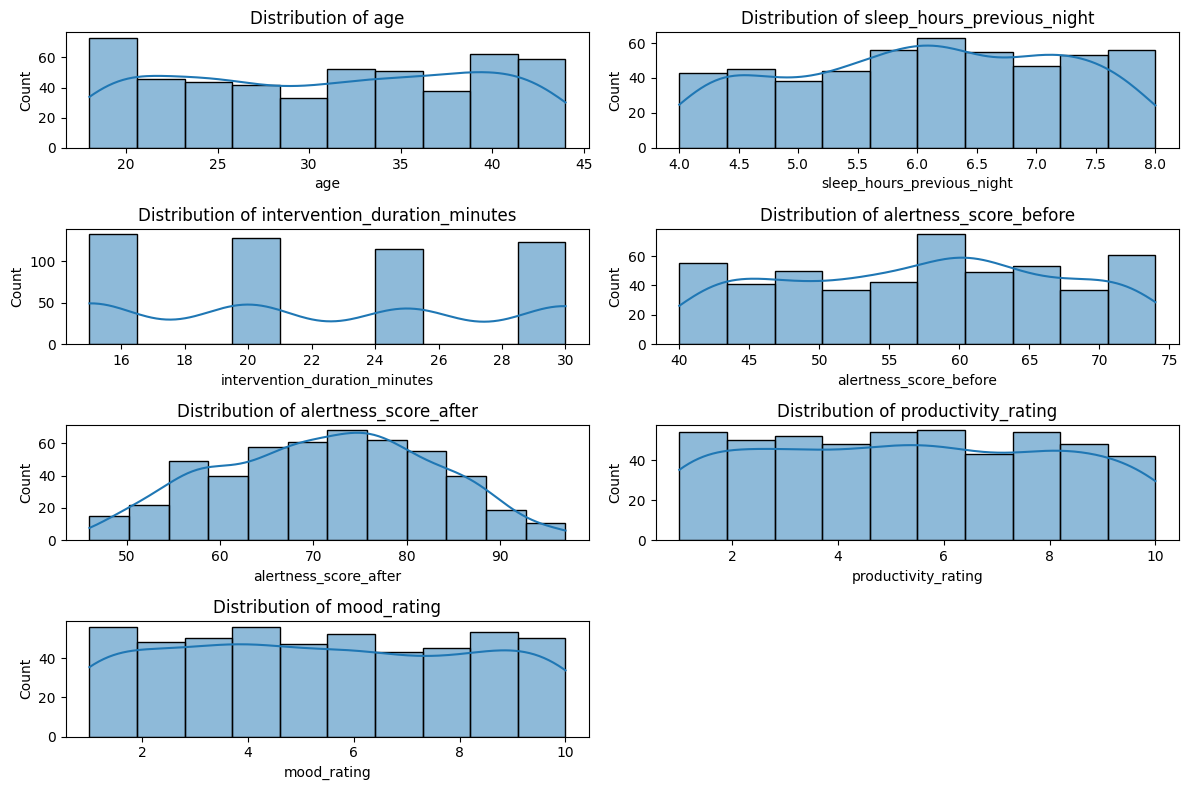

In [102]:
numerical_features = ['age','sleep_hours_previous_night', 'intervention_duration_minutes',
                  'alertness_score_before', 'alertness_score_after',
                  'productivity_rating', 'mood_rating']

fig, axs = plt.subplots(4,2 , figsize=(12, 8))

# axs.ravel() flattens the 2D array of axes into a 1D array for easy iteration
# the zip function pairs each axis with a numerical column
for i, (ax, col) in enumerate(zip(axs.ravel(), numerical_features)):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

# Remove any unused subplots
for i in range(len(numerical_features), len(axs.ravel())):
    fig.delaxes(axs.ravel()[i])

fig.tight_layout()

As can be seen, the distributions of the numerical features vary significantly. For example, the `Age` feature appears to be right-skewed, while the `Fare` feature has a long tail with some passengers paying very high fares. It is also important to mention that these columns have vastly different ranges of values, which will be addressed during preprocessing.

We should apply scaling techniques to our numerical features to ensure that they are on a similar scale. Additionally, for the `Fare` feature specifically, we may consider applying a power transformation to reduce the impact of extreme values and make the distribution more Gaussian-like.

## Visualization of Categorical Features



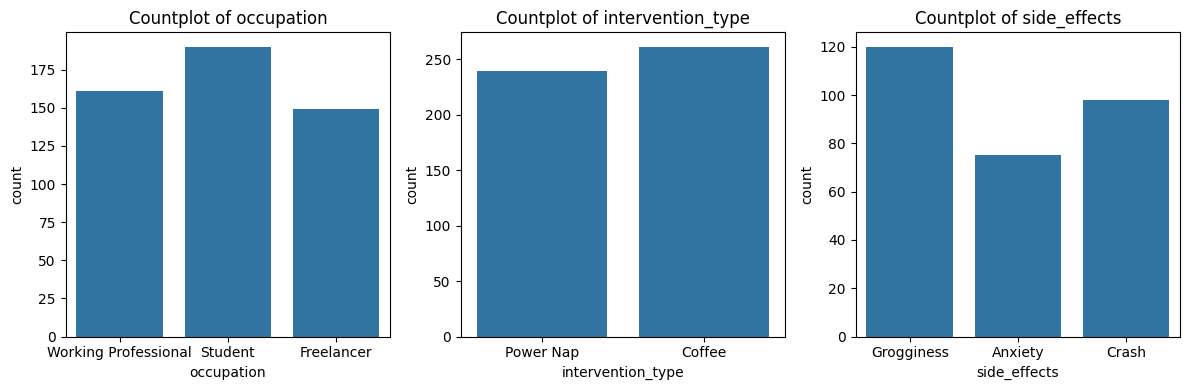

In [103]:
categorical_features = ['occupation', 'intervention_type', 'side_effects']

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for ax, col in zip(axs.ravel(), categorical_features):
    sns.countplot(data=data, x=col, ax=ax)
    ax.set_title(f'Countplot of {col}')

fig.tight_layout()


## Handling Missing Values

Before building preprocessing pipelines, it is important to analyze the missing values in the dataset. We can visualize the count of missing values for each column using a bar plot.

<Axes: >

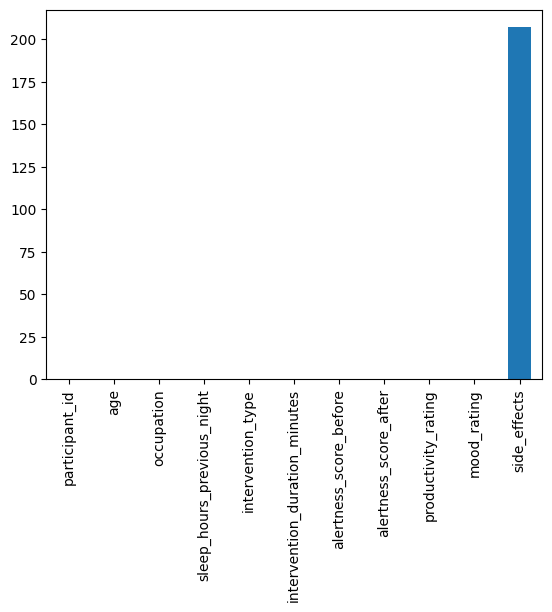

In [104]:
missing_counts = data.isnull().sum()
missing_counts.plot(kind='bar')

We can also calculate the percentage of missing values for each column to get a better understanding of the extent of missing data.

In [105]:
missing_percent = data.isnull().mean() * 100
missing_percent.sort_values(ascending=False)

,0
side_effects,41.4
age,0.0
participant_id,0.0
occupation,0.0
sleep_hours_previous_night,0.0
intervention_duration_minutes,0.0
intervention_type,0.0
alertness_score_before,0.0
alertness_score_after,0.0
productivity_rating,0.0


## Preprocessing pipelines



In [106]:
# Crear columna de target
data['alertness_improvement'] = (
    data['alertness_score_after'] - data['alertness_score_before']
)
target = 'alertness_improvement'

numerical_features = [
    'age',
    'sleep_hours_previous_night',
    'intervention_duration_minutes',
    'alertness_score_before',
    'productivity_rating',
    'mood_rating'
]

In [107]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=False
    ))
])

# Define numerical and categorical features explicitly within this cell for consistency
# These lists should align with how X is constructed.
current_numerical_features = [
    'age',
    'sleep_hours_previous_night',
    'intervention_duration_minutes',
    'alertness_score_before',
    'productivity_rating',
    'mood_rating'
]

current_categorical_features = [
    'occupation',
    'intervention_type',
    'side_effects'
]

preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, current_numerical_features),
        ('cat', categorical_pipeline, current_categorical_features)
    ],
    remainder='passthrough'
)

In [108]:
# Define the target variable
target_column = target  # 'alertness_improvement'

# Define feature columns (consistent with preprocessing)
feature_numerical_cols = numerical_features
feature_categorical_cols = categorical_features

X = data[feature_numerical_cols + feature_categorical_cols]
y = data[target_column]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


In [109]:
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_train_processed

array([[-0.97939992,  0.22743786, -0.4205322 , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.08954058, -0.74888075,  0.47421716, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.84613581,  0.22743786, -0.4205322 , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.22280469, -0.57136828,  1.36896652, ...,  0.        ,
         0.        ,  1.        ],
       [-1.34450707,  0.75997528, -1.31528156, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.33294534, -0.21634333,  1.36896652, ...,  0.        ,
         0.        ,  1.        ]])

In [110]:
X_test_processed = preprocessing_pipeline.transform(X_test)
X_test_processed

array([[-0.24918563,  1.55878142, -0.4205322 , ...,  0.        ,
         0.        ,  1.        ],
       [-1.22280469, -1.28141817, -0.4205322 , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.57635011,  0.49370657,  1.36896652, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.97939992, -1.37017441, -0.4205322 , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.21124296,  1.38126894, -1.31528156, ...,  0.        ,
         1.        ,  0.        ],
       [-0.73599516,  0.22743786, -0.4205322 , ...,  0.        ,
         0.        ,  1.        ]])

## Building a Regression Model


In [111]:
regression_model = make_pipeline(
    preprocessing_pipeline,
    LinearRegression()
)

In [112]:
regression_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'sleep_hours_previous_night',
                                                   'intervention_duration_minutes',
                                                   'alertness_score_before',
                                                   'productivity_rating',
                                                   'mood_rating']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['occupation',
                                                   'intervention_type',
                                                   'side_effects'])])),
                ('linearregression', LinearRegression())])

In [113]:
regression_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'sleep_hours_previous_night',
                                                   'intervention_duration_minutes',
                                                   'alertness_score_before',
                                                   'productivity_rating',
                                                   'mood_rating']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['occupation',
                                                   'intervention_type',
                                                   'side_effects'])])),
                ('linearregression', LinearRegression())])

In [114]:
y_test_pred = regression_model.predict(X_test)
y_test_pred

array([17.29929888, 17.22898252, 18.05057121, 18.18015939, 10.58023208,
       17.67655508, 18.86874402, 10.0584798 , 16.77421969, 16.62734661,
       10.71979269, 16.50208429, 10.54950239, 18.34781685, 18.05396227,
       10.96371178, 11.53409843, 17.51558566, 11.85864195, 17.33707207,
       17.63622925, 17.49092058, 16.67706051, 13.4194208 ,  9.39152744,
        9.52525746, 16.2212891 , 16.85751869, 11.21798124, 17.8128356 ,
       17.2955654 , 16.69339064, 15.73593798, 10.73921224, 10.56694809,
       16.89361995, 16.91146401, 16.79203481, 17.57507592, 16.49892236,
       17.61235837,  9.47405718, 16.95560767, 17.14419061, 17.29125365,
       11.83964512, 17.44304937,  9.04305125, 16.31697692, 12.45458327,
       16.00930758, 16.63485932, 16.36365455, 17.66003244, 17.19678605,
       10.09412   , 10.74834797, 17.92129614, 16.06138003, 10.97869476,
       11.8125174 ,  9.93467565, 17.90572273,  9.18290129, 11.11449439,
       11.24181343, 11.36652005, 17.01535408, 10.3627854 ,  8.81

In [115]:
X_test['alertness_improvement_predicted'] = y_test_pred
X_test['alertness_improvement_actual'] = y_test.values
X_test


,age,sleep_hours_previous_night,intervention_duration_minutes,alertness_score_before,productivity_rating,mood_rating,occupation,intervention_type,side_effects,alertness_improvement_predicted,alertness_improvement_actual
361,29,7.8,20,56,6,7,Working Professional,Power Nap,Grogginess,17.299299,10
73,21,4.6,20,64,9,8,Student,Power Nap,NaN,17.228983,13
374,44,6.6,30,49,5,7,Freelancer,Power Nap,Grogginess,18.050571,20
155,40,7.6,30,73,3,10,Student,Power Nap,NaN,18.180159,10
104,26,7.6,20,64,3,7,Student,Coffee,NaN,10.580232,6
...,...,...,...,...,...,...,...,...,...,...,...
347,18,5.4,30,58,2,10,Working Professional,Power Nap,NaN,16.810517,22
86,31,5.5,15,67,7,3,Working Professional,Power Nap,Grogginess,17.091212,13
75,23,4.5,20,73,4,2,Freelancer,Power Nap,NaN,17.393204,15
438,41,7.6,15,57,9,3,Freelancer,Coffee,Crash,11.435676,16
